## Analysis of Machine Learning Models on Cancer Classification

Alex Angus and Gray Selby

The goal of this project is to use mircroRNA (miRNA) profiles of cancer patients, provided by The Cancer Genome Atlas (TCGA) repository [1], to accurately predict the type of cancer that a patient has. A single patient’s miRNA profile is comprised of over 1800 individual miRNA expressions. Their correlations to specific cancer types are complicated, and likely codependent. This complexity is where machine learning algorithms, such as the ones we demonstrate in this analysis, are necessary. The TCGA dataset represents six kinds of cancers to classify: breast invasive carcinoma, kidney renal clear cell carcinoma, lung adenocarcinoma, lung squamous cell carcinoma, pancreatic adenocarcinoma, and uveal melanoma. In our analysis, we implement five ordinary classification models with the python **scikit-learn** package: **random forest, decision tree, support vector, multinomial logistic regression**, and **k-nearest neighbors**. We also implement a sixth **stacked ensemble classifier** with the mxlearn package.

First we import the necessary packages:

In [36]:
from organize import get_data
from cancer_classifiers import random_hyperparameter_search, grid_hyperparameter_search
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns
from mlxtend.classifier import StackingCVClassifier
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Exploration

Initially, the TCGA dataset is not aggregated into two discrete sets of example’s feature data and their respective labels, as is needed for training machine learning algorithms. The data is initially categorized by labels (cancer types), with files containing examples in each. In each example file is another file with feature data for that example. To ensure that the data is ready to be used for machine learning, we explore the dataset with the **explore_data()** function in the **organize.py** file. This function iterates through the examples of each cancer type to ensure that they have a uniform feature profile. Also in **organize.py**, we have written a function **combine_data()** that compiles and stores these data files into a 2-dimensional feature array (X) and a 1-dimensional label array (y) that can be accessed with the **get_data()** function.

We call the **get_data()** function to retrieve our aggregated dataset, then split into train and test sets. We also call **fit_transform()** to normalize our data.

In [13]:
"""
Shuffle and Split
"""
X, y = get_data()
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.fit_transform(X_test_)
print("Number of features: ", np.shape(X_train)[1])

Number of features:  1881


First, we train a **Random Forest Classifier** and a **Decision Tree Classifier**:

In [3]:
"""
Random Forest Model
"""
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
print("Number of features considered: ", rf_model.n_features_)
rf_accuracy = rf_model.score(X_test, y_test)
print("RF Accuracy: ", rf_accuracy)

Number of features considered:  1881
RF Accuracy:  0.9792746113989638


In [14]:
"""
Decision Tree Model
"""
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
print("Number of features considered: ", dt_model.n_features_)
dt_accuracy = dt_model.score(X_test, y_test)
print("Decision Tree Accuracy: ", dt_accuracy)

Number of features considered:  1881
Decision Tree Accuracy:  0.846286701208981


## Feature Selection

In the feature selection process, we remove features that, when considered, do not improve, or hinder the classification accuracy of our models. In this case, a feature corresponds to the presence of a specific miRNA in a patient’s profile.

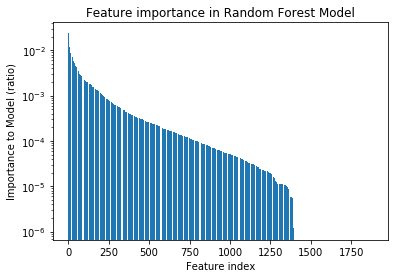

Sum of Random Forest Feature Importances:  1.0


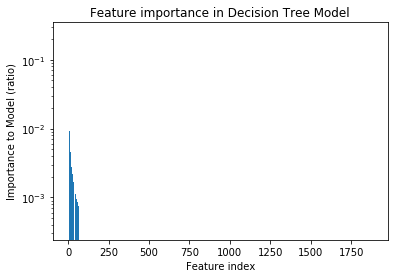

Sum of Decision Tree Feature Importances:  1.0


In [15]:
"""
Perform Feature Importance Analysis for RF and DT
"""
%matplotlib inline
rf_feature_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_feature_importances)[::-1]
plt.figure()
plt.yscale('log')
plt.xlabel("Feature index")
plt.ylabel("Importance to Model (ratio)")
plt.title("Feature importance in Random Forest Model")
plt.bar(range(X_train.shape[1]), rf_feature_importances[rf_indices],
        align='center')
plt.show()
print("Sum of Random Forest Feature Importances: ", round(sum(rf_feature_importances), 3))

dt_feature_importances = dt_model.feature_importances_
dt_indices = np.argsort(dt_feature_importances)[::-1]
plt.figure()
plt.yscale('log')
plt.xlabel("Feature index")
plt.ylabel("Importance to Model (ratio)")

plt.title("Feature importance in Decision Tree Model")
plt.bar(range(X_train.shape[1]), dt_feature_importances[dt_indices],
        align='center')
plt.show()
print("Sum of Decision Tree Feature Importances: ", round(sum(dt_feature_importances), 3))

Note that features with zero importance are not used to make a ’decision’ that decreases the entropy of the dataset. We see that the Decision Tree model has many more features with zero importance than the Random Forest model because the Random Forest is comprised of many trees, while the Decision Tree is a single tree.

To perform feature selection on the Random Forest (RF) and Decision Tree (DT) models, we use the attribute **feature_importances_** of the **RandomForestClassifier** and **DecisionTreeClassifier** classes to determine the importance of a feature to the model. 

In [16]:
"""
Perform Feature Selection
"""
rf_threshold = 5e-5
dt_threshold = 5e-4
rf_feature_selector = SelectFromModel(rf_model, threshold=rf_threshold, prefit=True)
dt_feature_selector = SelectFromModel(dt_model, threshold=dt_threshold, prefit=True)
X_train_rf_selected = rf_feature_selector.transform(X_train)
X_test_rf_selected = rf_feature_selector.transform(X_test)
X_train_dt_selected = dt_feature_selector.transform(X_train)
X_test_dt_selected = dt_feature_selector.transform(X_test)
print("New number of features in RF model: ", np.shape(X_train_rf_selected)[1])
print("New number of features in DT model: ", np.shape(X_train_dt_selected)[1])

New number of features in RF model:  1010
New number of features in DT model:  70


In [17]:
"""
Reassess RF and DT models
"""
rf_model_selected = RandomForestClassifier(n_estimators=100)
rf_model_selected.fit(X_train_rf_selected, y_train)
print("Number of features considered: ", rf_model_selected.n_features_)
rf_selected_accuracy = rf_model_selected.score(X_test_rf_selected, y_test)
print("Selective RF Accuracy: ", rf_selected_accuracy)
print("Change in RF Accuracy: ", round((rf_selected_accuracy - rf_accuracy)*100, 3), '%')
print()
dt_model_selected = DecisionTreeClassifier()
dt_model_selected.fit(X_train_dt_selected, y_train)
print("Number of features considered: ", dt_model_selected.n_features_)
dt_selected_accuracy = dt_model_selected.score(X_test_dt_selected, y_test)
print("Selective DT Accuracy: ", dt_selected_accuracy)
print("Change in DT Accuracy: ", round((dt_selected_accuracy - dt_accuracy)*100, 3), '%')

Number of features considered:  1010
Selective RF Accuracy:  0.9671848013816926
Change in RF Accuracy:  -1.209 %

Number of features considered:  70
Selective DT Accuracy:  0.8549222797927462
Change in DT Accuracy:  0.864 %


We see a moderate increase in accuracy in the decision tree model, with little to no change in accuracy in the random forest model. Our feature selection was, however, much more extreme in the DT case. We will now perform another round of feature selection on the RF model with a larger threshold for feature importance to try and improve the accuracy of our RF model.

In [18]:
"""
More extreme feature selection on the RF model.
"""
rf_threshold = 5e-4
rf_feature_selector = SelectFromModel(rf_model, threshold=rf_threshold, prefit=True)
X_train_rf_selected = rf_feature_selector.transform(X_train)
X_test_rf_selected = rf_feature_selector.transform(X_test)
rf_model_selected = RandomForestClassifier(n_estimators=100)
rf_model_selected.fit(X_train_rf_selected, y_train)
print("Number of features considered: ", rf_model_selected.n_features_)
rf_selected_accuracy = rf_model_selected.score(X_test_rf_selected, y_test)
print("Selective RF Accuracy: ", rf_selected_accuracy)
print("Change in RF Accuracy: ", round((rf_selected_accuracy - rf_accuracy)*100, 3), '%')
print()


Number of features considered:  335
Selective RF Accuracy:  0.9723661485319517
Change in RF Accuracy:  -0.691 %



After a more extreme feature selection process, accuracy is only marginally increased for the RF model.

Next we will take a look at a **Support Vector Classifier**, a **Logistic Regression Classifier**, and a **k-Nearest Neighbors** classifier.

In [19]:
"""
SVC Model
"""
svc_model = SVC(gamma='scale', kernel='linear')
svc_model.fit(X_train, y_train)
svc_accuracy = svc_model.score(X_test, y_test)
print("SVC Accuracy: ", svc_accuracy)

SVC Accuracy:  0.9550949913644214


In [20]:
"""
Logistic Regression Model
"""
lr_model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=10000)
lr_model.fit(X_train, y_train)
lr_accuracy = lr_model.score(X_test, y_test)
print("Logistic Regression Accuracy: ", lr_accuracy)

Logistic Regression Accuracy:  0.9637305699481865


In [21]:
"""
kNN Model
"""
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_accuracy = knn_model.score(X_test, y_test)
print("kNN Accuracy: ", knn_accuracy)

kNN Accuracy:  0.8272884283246977


We now perform a feature selection on the SVM and LR models in a manner similar to RF and DT, but this time we will let sklearn determine the threshold at which to eliminate features. 

In [22]:
"""
Feature selection of SVC model.
"""
svc_model.fit(X_train, y_train)
svc_feature_selector = SelectFromModel(svc_model, prefit=True)
X_train_svc_selected = svc_feature_selector.transform(X_train)
X_test_svc_selected = svc_feature_selector.transform(X_test)
svc_model_selected = SVC(gamma='scale', kernel='linear')
svc_model_selected.fit(X_train_svc_selected, y_train)
svc_selected_accuracy = svc_model_selected.score(X_test_svc_selected, y_test)
print("Selective SVC Accuracy: ", svc_selected_accuracy)
print("New number of SVC features: ", np.shape(X_train_svc_selected)[1])
print("Change in SVC Accuracy: ", round((svc_selected_accuracy - svc_accuracy)*100, 3), '%')
print()

Selective SVC Accuracy:  0.9516407599309153
New number of SVC features:  875
Change in SVC Accuracy:  -0.345 %



In [23]:
"""
Feature selection of LR model.
"""
lr_feature_selector = SelectFromModel(lr_model, prefit=True)
X_train_lr_selected = lr_feature_selector.transform(X_train)
X_test_lr_selected = lr_feature_selector.transform(X_test)
lr_model_selected = LogisticRegression()#multi_class='auto', solver='lbfgs',max_iter=10000)
lr_model_selected.fit(X_train_lr_selected, y_train)
lr_selected_accuracy = lr_model_selected.score(X_test_lr_selected, y_test)
print("Selective LR Accuracy: ", lr_selected_accuracy)
print("New number of LR features: ", np.shape(X_train_lr_selected)[1])
print("Change in LR Accuracy: ", round((lr_selected_accuracy - lr_accuracy)*100, 3), '%')


Selective LR Accuracy:  0.9689119170984456
New number of LR features:  835
Change in LR Accuracy:  0.518 %


We see that feature selection results in a marginal increase in accuracy of the support vector classifier and the logistic regression classifier.

The k-Nearest Neighbors classifier differs from the other considered models in that there is no training portion of the algorithm. Therefore, in order to have a feature importance metric for the kNN classifier, we would need to create models that omit one feature at a time, and compare the performance of these individual models. For this dataset, that would mean implementing 1881 models, which would take entirely too long, as kNN is already a computationally intense algorithm. The following code trains those models, but to run it would take a very long time.

In [ ]:
feature_importances = np.zeros(X_train.shape[1], dtype=float)
for feature in range(X_train.shape[1]):
    X_front = np.atleast_2d(X_train[:, 0:feature])
    X_back = np.atleast_2d(X_train[:, feature+1:])
    X_train_subset = np.hstack((X_front, X_back))
    score = cross_val_score(knn_model, X_train_subset, y_train, cv=5).mean()
    feature_importances[feature] = score

## Hyperparameter Tuning

We preform hyperparameter tuning by running a random hyperparameter search with scikitlearn’s **RandomizedSearchCV** class and running a grid hyperparameter search around the best hyperparameters found in the random search with scikitlearn’s **GridSearchCV**. Each model (except in the case of k-nearest neighbors, where the concept of over-fitting does not apply) includes hyperparameters that penalize over-fitting such as **max_depth** in the RF and DT models. By preforming hyperparameter searches with cross validation, the optimal over-fitting penalizing hyperparameters are found. With these hyperparameters, we ensure that we minimize bias and preserve model accuracy from dataset to dataset.

In [ ]:
"""
Random Forest Random Hyperparameter Search
"""
#number of trees
n_estimators = [int(x) for x in np.linspace(20, 500, 20)]
#number of features considered at each split
max_features = ['sqrt', 'auto']
#maximum tree depth
max_depth = [int(x) for x in np.linspace(10, 100, 20)]
#minimum number of samples to split a node
min_samples_split = [2, 3, 5]
#minimum number of samples at each leaf
min_samples_leaf = [1, 2, 4]
#bootstrap or not
bootstrap = [True, False]
#number of permutations
random_iterations = 25
validation_folds = 5
rf_hyperparameters =  {'n_estimators' : n_estimators,
                       'max_features' : max_features,
                       'max_depth' : max_depth,
                       'min_samples_split' : min_samples_split,
                       'min_samples_leaf' : min_samples_leaf,
                       'bootstrap' : bootstrap}
random_hyperparameter_search(rf_model_selected, rf_hyperparameters, random_iterations,
                             validation_folds, X_train_rf_selected, y_train, X_test_rf_selected, y_test)


In [ ]:
"""
Decision Tree Random Hyperparameter Search
"""
splitter = ['best', 'random']
max_features = ['sqrt', 'log2']
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, 10)]
min_samples_split = [2, 3, 5]
min_samples_leaf = [1, 2, 4]
max_depth = [int(x) for x in np.linspace(10, 200, 20)]
max_leaf_nodes.append(None)
presort = [True, False]
random_iterations = 25
validation_folds = 5
dt_hyperparameters = {'splitter' : splitter,
                      'max_features' : max_features,
                      'max_depth' : max_depth,
                      'max_leaf_nodes' : max_leaf_nodes,
                      'presort' : presort,
                      'min_samples_split' : min_samples_split,
                      'min_samples_leaf' : min_samples_leaf}
random_hyperparameter_search(dt_model_selected, dt_hyperparameters, random_iterations,
                             validation_folds, X_train_dt_selected, y_train, X_test_dt_selected, y_test)


In [ ]:
"""
SVC Random Hyperparameter Search
"""
C = [float(x) for x in np.linspace(0.01, 5, 20)]
kernel = ['linear', 'rbf', 'sigmoid']
gamma = ['auto', 'scale']
svc_hyperparameters = {'C' : C,
                       'kernel' : kernel,
                       'gamma' : gamma}
random_hyperparameter_search(svc_model_selected, svc_hyperparameters, random_iterations,
                             validation_folds, X_train_svc_selected, y_train, X_test_svc_selected, y_test)


In [ ]:
"""
Logistic Regression Random Hyperparameter Search
"""
C = [float(x) for x in np.linspace(0.1, 3.0, 20)]
fit_intercept = [True, False]
max_iter = [int(x) for x in np.linspace(100, 10000, 100)]
multi_class = ['ovr']
lr_hyperparameters = {'C' : C,
                      'fit_intercept' : fit_intercept,
                      'max_iter' : max_iter,
                      'multi_class' : multi_class}
random_hyperparameter_search(lr_model_selected, lr_hyperparameters, random_iterations,
                             validation_folds, X_train_lr_selected, y_train, X_test_lr_selected, y_test)


In [ ]:
"""
KNN Random Hyperparameter Search
"""
n_neighbors = [int(x) for x in np.linspace(1, 10, 10)]
weights = ['uniform', 'distance']
leaf_size = [int(x) for x in np.linspace(20, 40, 20)]
knn_hyperparameters = {'n_neighbors' : n_neighbors,
                       'weights' : weights,
                       'leaf_size' : leaf_size}
random_hyperparameter_search(knn_model, knn_hyperparameters, random_iterations,
                             validation_folds, X_train, y_train, X_test, y_test)


In [25]:
"""
Random Forest Grid Search

results of random forest random hyperparameter search:

{'n_estimators': 146, 
'min_samples_split': 2, 
'min_samples_leaf': 2, 
'max_features': 'auto', 
'max_depth': 38, 
'bootstrap': False}
"""
rf_hyperparameters =  {'n_estimators' : [int(x) for x in np.linspace(140, 150, 10)],
                       'max_features' : ['auto'],
                       'max_depth' : [int(x) for x in np.linspace(35, 42, 7)],
                       'min_samples_split' : [2],
                       'min_samples_leaf' : [2],
                       'bootstrap' : [False]}
                       
grid_hyperparameter_search(rf_model_selected, rf_hyperparameters,
                validation_folds, X_train_rf_selected, y_train, X_test_rf_selected, y_test)

Performing Hyperparameter Grid Search with hyperparameters:
{'bootstrap': [False],
 'max_depth': [35, 36, 37, 38, 39, 40, 42],
 'max_features': ['auto'],
 'min_samples_leaf': [2],
 'min_samples_split': [2],
 'n_estimators': [140, 141, 142, 143, 144, 145, 146, 147, 148, 150]}
Best hyperparameters:  {'bootstrap': False, 'max_depth': 39, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 140}
Best hyperparameter accuracy:  0.9689119170984456



Random Forest Classifier


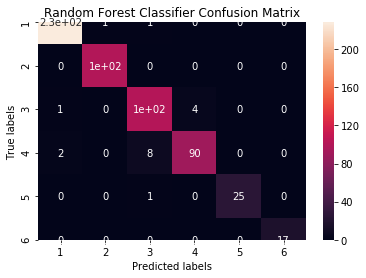

Random forest accuracy: 
0.9689119170984456

Classification Report: 
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       0.99      0.99      0.99       230
Kidney Renal Clear Cell Carcinoma       0.99      1.00      1.00       100
              Lung Adenocarcinoma       0.91      0.95      0.93       106
     Lung Squamous Cell Carcinoma       0.96      0.90      0.93       100
        Pancreatic Adenocarcinoma       1.00      0.96      0.98        26
                   Uveal Melanoma       1.00      1.00      1.00        17

                         accuracy                           0.97       579
                        macro avg       0.97      0.97      0.97       579
                     weighted avg       0.97      0.97      0.97       579



In [26]:
"""
Best hyperparameters:  
{'bootstrap': False, 
'max_depth': 36, 
'max_features': 'auto', 
'min_samples_leaf': 2, 
'min_samples_split': 2, 
'n_estimators': 145}
"""
print('')
print('Random Forest Classifier')
rf_model_selected = RandomForestClassifier(bootstrap = False, 
                                        max_depth = 36, 
                                        max_features = 'auto', 
                                        min_samples_leaf = 2, 
                                        min_samples_split = 2, 
                                        n_estimators = 145)
rf_model_selected.fit(X_train_rf_selected, y_train)
rf_predictions = rf_model_selected.predict(X_test_rf_selected)
rf_results = confusion_matrix(y_test, rf_predictions)
ax = plt.subplot()
sns.heatmap(rf_results, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Classifier Confusion Matrix')
ax.xaxis.set_ticklabels(['1','2','3','4','5','6'])
ax.yaxis.set_ticklabels(['1','2','3','4','5','6'])  
plt.show()
print('Random forest accuracy: ')
print(rf_model_selected.score(X_test_rf_selected, y_test))
print('')
print('Classification Report: ')
print(classification_report(y_test, rf_predictions))

In [27]:
"""
Decision Tree Grid Search

results of decision tree random hyperparameter search:

{'splitter': 'best', 
'presort': False, 
'min_samples_split': 3, 
'min_samples_leaf': 2, 
'max_leaf_nodes': 500, 
'max_features': 'sqrt', 
'max_depth': 130}
"""
dt_hyperparameters =  {'splitter' : ['best'],
                       'max_features' : ['sqrt'],
                       'max_depth' : [int(x) for x in np.linspace(125, 135, 10)],
                       'min_samples_split' : [3],
                       'min_samples_leaf' : [2],
                       'max_leaf_nodes' : [int(x) for x in np.linspace(495, 505, 10)],
                       'presort' : [False]}
                       
grid_hyperparameter_search(dt_model_selected, dt_hyperparameters,
                validation_folds, X_train_dt_selected, y_train, X_test_dt_selected, y_test)

Performing Hyperparameter Grid Search with hyperparameters:
{'max_depth': [125, 126, 127, 128, 129, 130, 131, 132, 133, 135],
 'max_features': ['sqrt'],
 'max_leaf_nodes': [495, 496, 497, 498, 499, 500, 501, 502, 503, 505],
 'min_samples_leaf': [2],
 'min_samples_split': [3],
 'presort': [False],
 'splitter': ['best']}
Best hyperparameters:  {'max_depth': 132, 'max_features': 'sqrt', 'max_leaf_nodes': 500, 'min_samples_leaf': 2, 'min_samples_split': 3, 'presort': False, 'splitter': 'best'}
Best hyperparameter accuracy:  0.7443868739205527



Decision Tree Classifier


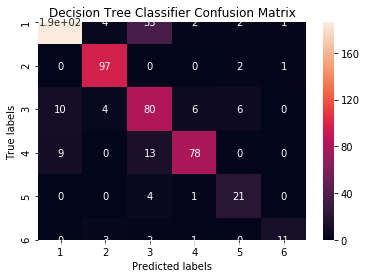

Decision Tree accuracy: 
0.8169257340241797

Classification Report: 
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       0.91      0.81      0.86       230
Kidney Renal Clear Cell Carcinoma       0.90      0.97      0.93       100
              Lung Adenocarcinoma       0.60      0.75      0.67       106
     Lung Squamous Cell Carcinoma       0.89      0.78      0.83       100
        Pancreatic Adenocarcinoma       0.68      0.81      0.74        26
                   Uveal Melanoma       0.85      0.65      0.73        17

                         accuracy                           0.82       579
                        macro avg       0.80      0.79      0.79       579
                     weighted avg       0.83      0.82      0.82       579



In [28]:
"""
Best hyperparameters:  
{'max_depth': 133, 
'max_features': 'sqrt', 
'max_leaf_nodes': 495, 
'min_samples_leaf': 2, 
'min_samples_split': 3, 
'presort': False, 
'splitter': 'best'}
"""
print('')
print('Decision Tree Classifier')
dt_model_selected = DecisionTreeClassifier(max_depth = 133, 
                                           max_features = 'sqrt', 
                                           max_leaf_nodes = 495, 
                                           min_samples_leaf = 2, 
                                           min_samples_split = 3, 
                                           presort = False, 
                                           splitter = 'best')
dt_model_selected.fit(X_train_dt_selected, y_train)
dt_predictions = dt_model_selected.predict(X_test_dt_selected)
dt_results = confusion_matrix(y_test, dt_predictions)
ax = plt.subplot()
sns.heatmap(dt_results, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Decision Tree Classifier Confusion Matrix')
ax.xaxis.set_ticklabels(['1','2','3','4','5','6'])
ax.yaxis.set_ticklabels(['1','2','3','4','5','6'])  
plt.show()
print('Decision Tree accuracy: ')
print(dt_model_selected.score(X_test_dt_selected, y_test))
print('')
print('Classification Report: ')
print(classification_report(y_test, dt_predictions))

In [29]:
"""
SVC Grid Hyperparameter Search

results of svc random hyperparameter search:

{'kernel': 'linear', 'gamma': 'auto', 'C': 0.01}
"""
svc_hyperparameters = {'C' : [float(x) for x in np.linspace(0.005, 0.015, 10)],
                       'kernel' : ['linear'],
                       'gamma' : ['auto']}
grid_hyperparameter_search(svc_model_selected, svc_hyperparameters,
                             validation_folds, X_train_svc_selected, y_train, X_test_svc_selected, y_test)


Performing Hyperparameter Grid Search with hyperparameters:
{'C': [0.005,
       0.0061111111111111106,
       0.007222222222222222,
       0.008333333333333333,
       0.009444444444444443,
       0.010555555555555554,
       0.011666666666666665,
       0.012777777777777777,
       0.013888888888888888,
       0.015],
 'gamma': ['auto'],
 'kernel': ['linear']}
Best hyperparameters:  {'C': 0.005, 'gamma': 'auto', 'kernel': 'linear'}
Best hyperparameter accuracy:  0.9550949913644214



Support Vector Classifier


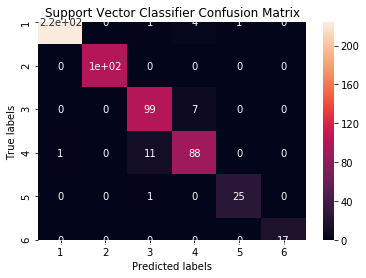

Support Vector accuracy: 
0.9550949913644214

Classification Report: 
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       1.00      0.97      0.98       230
Kidney Renal Clear Cell Carcinoma       1.00      1.00      1.00       100
              Lung Adenocarcinoma       0.88      0.93      0.91       106
     Lung Squamous Cell Carcinoma       0.89      0.88      0.88       100
        Pancreatic Adenocarcinoma       0.96      0.96      0.96        26
                   Uveal Melanoma       1.00      1.00      1.00        17

                         accuracy                           0.96       579
                        macro avg       0.95      0.96      0.96       579
                     weighted avg       0.96      0.96      0.96       579



In [30]:
"""
Best hyperparameters:  
{'C': 0.005, 
'gamma': 'auto', 
'kernel': 'linear'}
"""
print('')
print('Support Vector Classifier')
svc_model_selected = SVC(C = 0.005, gamma='scale', kernel='linear')
svc_model_selected.fit(X_train_svc_selected, y_train)
svc_predictions = svc_model_selected.predict(X_test_svc_selected)
svc_results = confusion_matrix(y_test, svc_predictions)
ax = plt.subplot()
sns.heatmap(svc_results, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Support Vector Classifier Confusion Matrix')
ax.xaxis.set_ticklabels(['1','2','3','4','5','6'])
ax.yaxis.set_ticklabels(['1','2','3','4','5','6'])  
plt.show()
print('Support Vector accuracy: ')
print(svc_model_selected.score(X_test_svc_selected, y_test))
print('')
print('Classification Report: ')
print(classification_report(y_test, svc_predictions))

In [31]:
"""
Logistic Regression Grid Hyperparameter Search

results of LR random hyperparameter search:

{'multi_class': 'ovr',
'max_iter': 9400, 
'fit_intercept': True, 
'C': 0.25263157894736843}
"""
lr_hyperparameters = {'C' : [float(x) for x in np.linspace(0.2, 0.3, 10)],
                      'fit_intercept' : [True],
                      'max_iter' : [int(x) for x in np.linspace(9000, 10000, 10)],
                      'multi_class' : ['ovr']}
                             
grid_hyperparameter_search(lr_model_selected, lr_hyperparameters,
                             validation_folds, X_train_lr_selected, y_train, X_test_lr_selected, y_test)


Performing Hyperparameter Grid Search with hyperparameters:
{'C': [0.2,
       0.2111111111111111,
       0.22222222222222224,
       0.23333333333333334,
       0.24444444444444444,
       0.25555555555555554,
       0.26666666666666666,
       0.2777777777777778,
       0.28888888888888886,
       0.3],
 'fit_intercept': [True],
 'max_iter': [9000, 9111, 9222, 9333, 9444, 9555, 9666, 9777, 9888, 10000],
 'multi_class': ['ovr']}
Best hyperparameters:  {'C': 0.24444444444444444, 'fit_intercept': True, 'max_iter': 9000, 'multi_class': 'ovr'}
Best hyperparameter accuracy:  0.9689119170984456



Support Vector Classifier


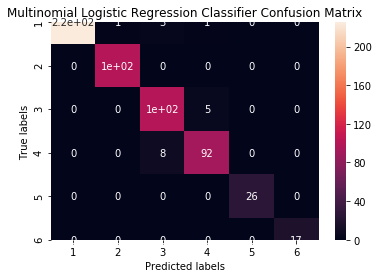

Multinomial Logistic Regression accuracy: 
0.9689119170984456

Classification Report: 
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       1.00      0.98      0.99       230
Kidney Renal Clear Cell Carcinoma       0.99      1.00      1.00       100
              Lung Adenocarcinoma       0.90      0.95      0.93       106
     Lung Squamous Cell Carcinoma       0.94      0.92      0.93       100
        Pancreatic Adenocarcinoma       1.00      1.00      1.00        26
                   Uveal Melanoma       1.00      1.00      1.00        17

                         accuracy                           0.97       579
                        macro avg       0.97      0.98      0.97       579
                     weighted avg       0.97      0.97      0.97       579



In [32]:
"""
Best hyperparameters:  
{'C': 0.24444444444444444, 
'fit_intercept': True, 
'max_iter': 9000, 
'multi_class': 'ovr'}
"""
print('')
print('Support Vector Classifier')
lr_model_selected = LogisticRegression(C = 0.24444444444444444, 
                                       fit_intercept = True, 
                                       max_iter = 9000, 
                                       multi_class = 'ovr')
lr_model_selected.fit(X_train_lr_selected, y_train)
lr_predictions = lr_model_selected.predict(X_test_lr_selected)
lr_results = confusion_matrix(y_test, lr_predictions)
ax = plt.subplot()
sns.heatmap(lr_results, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Multinomial Logistic Regression Classifier Confusion Matrix')
ax.xaxis.set_ticklabels(['1','2','3','4','5','6'])
ax.yaxis.set_ticklabels(['1','2','3','4','5','6'])  
plt.show()
print('Multinomial Logistic Regression accuracy: ')
print(lr_model_selected.score(X_test_lr_selected, y_test))
print('')
print('Classification Report: ')
print(classification_report(y_test, lr_predictions))

In [33]:
"""
KNN Grid Hyperparameter Search

results of random hyperparameter search (KNN):

{'weights': 'distance', 'n_neighbors': 7, 'leaf_size': 35}
"""

knn_hyperparameters = {'n_neighbors' : [int(x) for x in np.linspace(2, 8, 7)],
                       'weights' : ['distance'],
                       'leaf_size' : [int(x) for x in np.linspace(32, 37, 6)]}
validation_folds = 5
grid_hyperparameter_search(knn_model, knn_hyperparameters,
                             validation_folds, X_train, y_train, X_test, y_test)


Performing Hyperparameter Grid Search with hyperparameters:
{'leaf_size': [32, 33, 34, 35, 36, 37],
 'n_neighbors': [2, 3, 4, 5, 6, 7, 8],
 'weights': ['distance']}
Best hyperparameters:  {'leaf_size': 32, 'n_neighbors': 7, 'weights': 'distance'}
Best hyperparameter accuracy:  0.8324697754749568



k-Nearest Neighbor Classifier


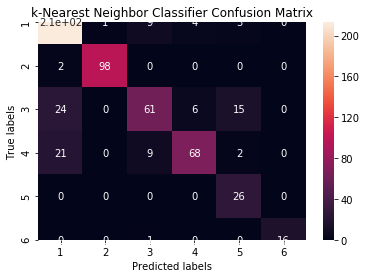

k-Nearest Neighbor accuracy: 
0.8324697754749568

Classification Report: 
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       0.82      0.93      0.87       230
Kidney Renal Clear Cell Carcinoma       0.99      0.98      0.98       100
              Lung Adenocarcinoma       0.76      0.58      0.66       106
     Lung Squamous Cell Carcinoma       0.87      0.68      0.76       100
        Pancreatic Adenocarcinoma       0.57      1.00      0.72        26
                   Uveal Melanoma       1.00      0.94      0.97        17

                         accuracy                           0.83       579
                        macro avg       0.83      0.85      0.83       579
                     weighted avg       0.84      0.83      0.83       579



In [34]:
"""
Best hyperparameters:  
{'leaf_size': 32, 
'n_neighbors': 7, 
'weights': 'distance'}
"""
print()
print('k-Nearest Neighbor Classifier')
knn_model = KNeighborsClassifier(leaf_size = 32, 
                                 n_neighbors = 7, 
                                 weights = 'distance')
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_results = confusion_matrix(y_test, knn_predictions)
ax = plt.subplot()
sns.heatmap(knn_results, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('k-Nearest Neighbor Classifier Confusion Matrix')
ax.xaxis.set_ticklabels(['1','2','3','4','5','6'])
ax.yaxis.set_ticklabels(['1','2','3','4','5','6'])  
plt.show()
print('k-Nearest Neighbor accuracy: ')
print(knn_model.score(X_test, y_test))
print()
print('Classification Report: ')
print(classification_report(y_test, knn_predictions))

## Model Stacking

We implement a sixth model with the ensemble method of stacking. With model stacking, each of our individual models is trained independently, and their predictions are then used as features to train a meta-classifier. The meta-classifier then makes the final prediction. We implement two stacked classifiers: one comprised of all our previous
3 models, and one with the top three performers. In both models, we find the Multinomial Logistic Regression Classifier to perform best as our meta-classifier.

In [38]:
"""
Stacked Classifier Assembly

model_parameters are the best performing parameters from the grid hyperparameter search.

We choose the logistic regression classifier as our 'meta classifier'.
"""
random_forest = RandomForestClassifier(bootstrap= False, 
                                         max_depth= 36, 
                                         max_features= 'auto', 
                                         min_samples_leaf= 2, 
                                         min_samples_split= 2, 
                                         n_estimators= 145)

decision_tree = DecisionTreeClassifier(max_depth= 133, 
                                     max_features= 'sqrt', 
                                     max_leaf_nodes= 495, 
                                     min_samples_leaf= 2, 
                                     min_samples_split= 3, 
                                     presort= False, 
                                     splitter= 'best')

svc = SVC(C= 0.005, gamma= 'auto', kernel= 'linear')

logistic_regression = LogisticRegression(C= 0.24444444444444444,
                 fit_intercept= True,
                 max_iter= 9000,
                 multi_class= 'ovr')


knn = KNeighborsClassifier(leaf_size= 32, 
                  n_neighbors= 7, 
                  weights= 'distance')

meta_classifier = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=10000)

#StackingCVClassifier will not take string labels
label_map = {'Breast Invasive Carcinoma' : 0,
             'Kidney Renal Clear Cell Carcinoma' : 1,
             'Lung Adenocarcinoma' : 2, 
             'Lung Squamous Cell Carcinoma' : 3,
             'Pancreatic Adenocarcinoma' : 4,
             'Uveal Melanoma' : 5}

y_ints = np.zeros(len(y_train))
for label in range(len(y_train)):
    for key in label_map.keys():
        if y_train[label] == key:
            y_ints[label] = label_map[key]
            break
                
stacked_classifier = StackingCVClassifier(classifiers=[random_forest,
                                                       decision_tree,
                                                       svc,
                                                       logistic_regression,
                                                       knn], 
                                                       meta_classifier=meta_classifier)

stacked_score = np.mean(cross_val_score(stacked_classifier, X_train, y_ints, 
                                              cv=5, scoring='accuracy'))

print("Accuracy of Stacked Classifier: ", stacked_score)

Accuracy of Stacked Classifier:  0.9688958077992906


In [39]:
"""
Stacked Classifier of only highest performing models (RF, SVC, LR).
"""
stacked_classifier_selective = StackingCVClassifier(classifiers=[random_forest,
                                                    svc,
                                                    logistic_regression], 
                                                    meta_classifier=meta_classifier)
stacked_score_selective = np.mean(cross_val_score(stacked_classifier_selective,
                                                                  X_train, y_ints, cv=5, scoring='accuracy'))

print("Accuracy of Selective Stacked Classifier: ", stacked_score_selective)

Accuracy of Selective Stacked Classifier:  0.9688883521121177


## Conclusions

Through a scoring metric based on precision, recall, and f-1 score, we determine that our **Random Forest Classifier model preforms the best**, with all three of these values peaking at 98%. 

The random forest classification report shows perfect classification of breast invasive carcinoma, kidney renal clear cell carcinoma, pancreatic adenocarcinoma, and uveal melanoma, while the model classifies lung adenocarcinoma and lung squamous cell carcinoma with over 90% accuracy. The logistic regression classification report shows perfect classification of breast invasive carcinoma, kidney renal clear cell carcinoma, and uveal melanoma with over 95% accuracy for lung adenocarcinoma, lung squamous cell carcinoma, and pancreatic adenocarcinoma.

All of our models classify uveal melanoma with 100% accuracy. For kidney renal clear cell carcinoma our Random Forest, Decision Tree, and Logistic Regression models classify with 100% accuracy, while our k-Nearest Neighbor model performs with 99% accuracy. For all models, lung adenocarcinoma is classified with the worst accuracy when compared with other cancer types.

Given how different models are better classifiers of different cancer types, our stacked classifier seems to be a reliable classifier boasting 96.9% accuracy even when including the less reliable k-Nearest Neighbor classifier. However, the Random Forest Classifier alone produces higher accuracy.